In [1]:

import os 
join = os.path.join

In [2]:
params_composite ={
    "r"         :  0.25,
    "h"         :  0.65,
    "z0"        :  2.82/2,
    "density"   : 8,
    "interface_factor"  :  1.2,
    "with_interface"    : False,
    "mirror"            : True,
    "check_jacobian"    : False,
}

params_ccx = {
    "epsilon" : 0.1,
}
params = {
    "mesh" : params_composite,
    "ccx"  : params_ccx,
}

In [3]:

from djccx.read_dat import read_dat

def compute_vol_frac(dat_path):
    dat = read_dat(dat_path)
    vols = [ idat["df"]["volume"].sum() for idat in dat]
    vT = vols[1]
    v_yarns = vols[0]/vT
    v_alma  = vols[2]/vT
    v_matrix = 1 - v_yarns - v_alma
    return {
        "yarns"  : v_yarns,
        "matrix" : v_matrix,
        "alma"   : v_alma,
    }

In [4]:
import numpy as np

In [5]:
np.linspace(0.2 ,0.3,5)

array([0.2  , 0.225, 0.25 , 0.275, 0.3  ])

In [6]:
r_span = np.linspace(0.15 ,0.25,5)
r_span

array([0.15 , 0.175, 0.2  , 0.225, 0.25 ])

In [7]:
from djccx.frd.readfrd import readfrd

In [8]:
import glob,os
join = os.path.join

In [9]:
frd_files = glob.glob(join("output","r_*","ccx","B1","*.frd"),recursive=True)
frd_files

['output\\r_00\\ccx\\B1\\main.frd',
 'output\\r_01\\ccx\\B1\\main.frd',
 'output\\r_02\\ccx\\B1\\main.frd',
 'output\\r_03\\ccx\\B1\\main.frd',
 'output\\r_04\\ccx\\B1\\main.frd']

In [10]:
dat_files = glob.glob(join("output","r_*","ccx","B1","*.dat"),recursive=True)

In [11]:
ancho = params_composite["z0"] + 0.5*params_composite["h"]
largo = 10 
A = ancho*largo

def compute_Fapl(iffiles):
    ifrd = readfrd(iffiles)
    df = ifrd["data"]
    Fapl = np.sum(df["F2"]*(df["y"] > df["y"].mean()))

    return Fapl

Fapl = [compute_Fapl(f) for f in frd_files]
Sapl = [f/A for f in Fapl]
E_eff = [s / params["ccx"]["epsilon"] for s in Sapl]

In [12]:
vfracs = [compute_vol_frac(f) for f in dat_files]

In [13]:
vfracs

[{'yarns': np.float64(0.024442020819347092),
  'matrix': np.float64(0.35019774830435135),
  'alma': np.float64(0.6253602308763015)},
 {'yarns': np.float64(0.03326885491821474),
  'matrix': np.float64(0.341370914702369),
  'alma': np.float64(0.6253602303794162)},
 {'yarns': np.float64(0.04345301317283831),
  'matrix': np.float64(0.3311867555240263),
  'alma': np.float64(0.6253602313031353)},
 {'yarns': np.float64(0.054995192085211274),
  'matrix': np.float64(0.3196445769058668),
  'alma': np.float64(0.6253602310089219)},
 {'yarns': np.float64(0.06789599357693947),
  'matrix': np.float64(0.3067437768917928),
  'alma': np.float64(0.6253602295312678)}]

In [14]:
from validation.experimental import carbonfiber,resina,nucleo

carbon = carbonfiber()
Ecarbon_MPa = carbon["carbon"].iloc[0]["Young Modulus (GPa)"]*1e3
resina = resina()
nucleo = nucleo()

In [15]:
def analytical(r):
    v_y  = r["yarns"]
    v_m  = r["matrix"]
    v_a  = r["alma"]

    E_y = Ecarbon_MPa
    E_m = resina["young modulus [MPa]"]
    E_a = nucleo["young modulus [MPa]"]

    E_sy = 1/(v_y/E_y + v_m/E_m)
    v_sy = v_y + v_m
    return  E_sy*v_sy + v_a*E_a

E_eff_analytical = [analytical(v) for v in vfracs]
v_carbon = [v["yarns"] for v in vfracs]

In [16]:
def analytical(r):

    h = params_composite["h"]
    z0 = params_composite["z0"]
    Lx = 10

    h_al = z0 - h/2
    
    f_y  = r["yarns"]
    f_m  = r["matrix"]
    h_tot = h + h_al

    radius = np.sqrt(f_y*h_tot*Lx/(6*np.pi))  
    d = 2*radius

    # print("h_tot = ",h_tot)
    # print("z0 = ",z0)
    # print("radius = ",radius)    
    # print("diamentro = ",d)
    # print("Lx = ",Lx)

    E_c = Ecarbon_MPa
    E_m = resina["young modulus [MPa]"]
    E_n = nucleo["young modulus [MPa]"]

    f_c_ast = d/(h_tot)
    f_n = h_al/(h_tot)
    f_m = (h-d)/(h_tot)

    f_c = 6*d/Lx 

    E_c_ast = 1/(f_c/E_c + (1-f_c)/E_m)

    E_eff = f_c_ast*E_c_ast + f_m*E_m + f_n*E_n

    return E_eff

E_eff_analytical = [analytical(v) for v in vfracs]
v_carbon = [v["yarns"] for v in vfracs]

In [17]:
E_y = Ecarbon_MPa
E_m = resina["young modulus [MPa]"]
E_a = nucleo["young modulus [MPa]"]

In [18]:
print("Carbon",Ecarbon_MPa)
print("Resina",resina["young modulus [MPa]"])
print("Nucleo",nucleo["young modulus [MPa]"])

Carbon 230000.0
Resina 2549.7289999999994
Nucleo 800


In [19]:
from matplotlib import pyplot as plt

In [20]:
v_carbon = np.array(v_carbon)

(0.0, 1883.9451053604764)

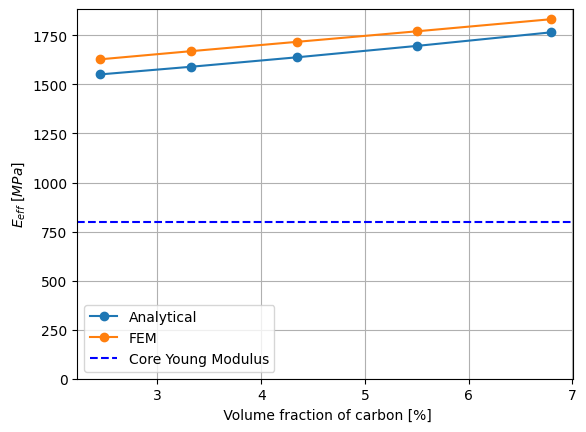

In [29]:
from matplotlib import pyplot as plt
plt.plot(100*v_carbon,E_eff_analytical,"o-",label="Analytical")
plt.plot(100*v_carbon,E_eff,"o-",label="FEM")
# plt.axhline(y=E_m, color='g', linestyle='--', label='Matrix Young Modulus')
plt.axhline(y=E_a, color='b', linestyle='--', label='Core Young Modulus')

plt.ylabel(r"$E_{eff} \ [MPa]$")
plt.xlabel(" Volume fraction of carbon [%]")
plt.legend()
# grid
plt.grid()
plt.ylim([0,None])

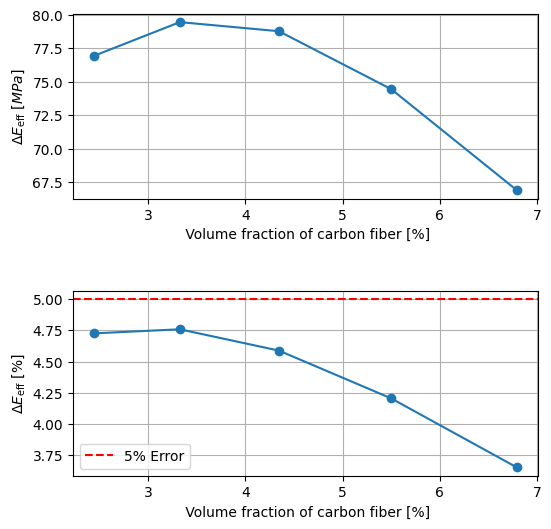

In [30]:
# error 

error = np.abs(np.array(E_eff_analytical) - np.array(E_eff))
plt.figure( figsize=(6,6) )
# padding subplot h=0.5
plt.subplots_adjust(hspace=0.5)

plt.subplot(2,1,1)
plt.plot(100*v_carbon,error,"o-")

plt.ylabel(r"$\Delta E_{\text{eff}} \ [MPa]$")
plt.xlabel(" Volume fraction of carbon fiber [%]")
plt.grid()

plt.subplot(2,1,2)
error_rel = error / np.array(E_eff)

plt.plot(100*v_carbon,100*error_rel,"o-")
plt.axhline(y=5, color='r', linestyle='--', label='5% Error')

# 
plt.ylabel(r"$\Delta E_{\text{eff}} \ [\%]$")
plt.xlabel(" Volume fraction of carbon fiber [%]")
plt.grid()
plt.legend()



In [31]:
import pandas as pd
df_save = pd.DataFrame({"vfrac":vfrac_FEM,"E":E_eff})
df_save.to_csv("E_eff_analytical.csv",index=False)

NameError: name 'vfrac_FEM' is not defined